In [46]:
# %%
import os
import sys
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import json
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import re
from utils.beh_functions import parseSessionID, session_dirs, get_unit_tbl, get_session_tbl, makeSessionDF
from utils.ephys_functions import plot_rate, correlate_nan_bi, correlate_nan, load_drift, get_spike_matrix
from utils.lick_utils import load_licks
from utils.photometry_utils import bin_timeseries_around_align
from utils.pupil_utils import load_pupil
from aind_ephys_utils import align
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
from matplotlib import colormaps
import pickle
import shutil
import datetime
import seaborn as sns
from trimesh import load_mesh
from utils.plot_utils import combine_pdf_big
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
from aind_ephys_utils import align
import numbers
from scipy.interpolate import interp1d
from scipy.stats import pearsonr
%matplotlib widget

In [59]:
# plot unit vs pupil correlation
# def plot_unit_pupil_correlation(session, opto_only=True, bin_size=0.1):
def plot_unit_pupil_correlation():
    session = 'behavior_ZS062_2021-04-28_17-53-01'
    opto_only = True
    bin_size=5
    step_size=0.1
    bin_size_short=0.5
    win_length=10
    trial_duration = [-0.01, 3.5]
    plot = True
    session_dir = session_dirs(session_id=session)
    unit_tbl = get_unit_tbl(session, data_type='curated')
    sesssion_df = get_session_tbl(session)
    pupil_data = load_pupil(session)
    if pupil_data is None:
        print(f'No pupil data for session {session}')
    if opto_only:
        unit_tbl = unit_tbl[unit_tbl['opto_pass']]

    pupil_times = pupil_data['pupil_times']
    pupil_values = pupil_data['pupil_diameter_z']
    # set those in trials not pass quality to nan

    gs = gridspec.GridSpec(len(unit_tbl), 3, width_ratios=[1,0.2,0.2])

    # load session quality metrics
    session_qm_file = os.path.join(session_dir['processed_dir'], f'{session}_qm.json')
    with open(session_qm_file, 'r') as f:
        session_qm = json.load(f)
    rec_start = session_qm['ephys_cut'][0]
    rec_end = session_qm['ephys_cut'][1]

    results = []

    for i, row in unit_tbl.iterrows():
        spike_times = row['spike_times']
        drift = load_drift(session, row['unit_id'], 'curated')
        start_unit = rec_start
        end_unit = rec_end
        session_tbl_curr = sesssion_df.copy()
        if drift is not None:
            if drift['ephys_cut'][0] is not None:
                start_unit = max(start_unit, drift['ephys_cut'][0])
                if session_tbl_curr is not None:
                    session_tbl_curr = session_tbl_curr[session_tbl_curr['goCue_start_time'] >= drift['ephys_cut'][0]]
            if drift['ephys_cut'][1] is not None:
                end_unit = min(end_unit, drift['ephys_cut'][1])
                if session_tbl_curr is not None:
                    session_tbl_curr = session_tbl_curr[session_tbl_curr['goCue_start_time'] <= drift['ephys_cut'][1]]

        pupil_values_no_trial = pupil_values.copy()
        if session_tbl_curr is not None and len(session_tbl_curr) > 0:
            trial_starts = session_tbl_curr['goCue_start_time'].values + trial_duration[0]
            trial_ends = session_tbl_curr['goCue_start_time'].values + trial_duration[1]
            mask_tmp = np.ones_like(pupil_values, dtype=bool)
            for start, end in zip(trial_starts, trial_ends):
                # if any part of the bin overlaps with trial, set to nan
                mask_tmp[(pupil_times >= start) & (pupil_times <= end)] = False
            pupil_values_no_trial[~mask_tmp] = np.nan

        # correlation bewtween spike rate and pupil size
        start_unit = max(start_unit, pupil_times[0])
        end_unit = min(end_unit, pupil_times[-1])

        # including trial time
        # calculate spike counts in bins with each step at step_size
        bin_starts = np.arange(start_unit, end_unit-bin_size, step_size)
        bin_ends = bin_starts + bin_size
        left = np.searchsorted(spike_times, bin_starts, side="left")
        right = np.searchsorted(spike_times, bin_ends, side="left")  # [start, end)
        spike_counts = right - left
        spike_counts = spike_counts / bin_size  # convert to rate

        pupil_dia_binned, bin_centers = bin_timeseries_around_align(ts={'time': pupil_times, 'value': pupil_values},
                                                        align_times=np.array([start_unit]),
                                                        step_size=step_size,
                                                        bin_size=bin_size,
                                                        t_start=0,
                                                        t_stop=end_unit - start_unit)
        pupil_dia_binned = pupil_dia_binned.flatten()

        # excluding trial time
        spike_counts_no_trial = spike_counts.copy()
        if session_tbl_curr is not None and len(session_tbl_curr) > 0:
            trial_starts = session_tbl_curr['goCue_start_time'].values + trial_duration[0]
            trial_ends = session_tbl_curr['goCue_start_time'].values + trial_duration[1]
            # if part of the bin overlaps with trial, recompute spike count as part of the bin that does exclude trial
            for start, end in zip(trial_starts, trial_ends):
                # if any part of the bin overlaps with trial, set to nan
                # find bins that is completely in the trial
                mask = (bin_starts > start) & (bin_ends < end)
                spike_counts_no_trial[mask] = np.nan
                # find bins that partially overlap with trial that started before the trial
                mask_partial = (bin_starts < start) & (bin_ends > start) & (bin_ends < end)
                for idx in np.where(mask_partial)[0]:
                    # recompute spike count for this bin
                    bin_time = start - bin_starts[idx]
                    if bin_time >= 0.5*bin_size:
                        left_idx = np.searchsorted(spike_times, bin_starts[idx], side="left")
                        right_idx = np.searchsorted(spike_times, start, side="left")
                        spike_count_partial = right_idx - left_idx
                        spike_counts_no_trial[idx] = spike_count_partial / bin_time
                    else:
                        spike_counts_no_trial[idx] = np.nan
                # find bins that partially overlap with trial that ended after the trial
                mask_partial = (bin_starts > start) & (bin_starts < end) & (bin_ends > end)
                for idx in np.where(mask_partial)[0]:
                    # recompute spike count for this bin
                    bin_time = bin_ends[idx] - end
                    if bin_time >= 0.5*bin_size:
                        left_idx = np.searchsorted(spike_times, end, side="left")
                        right_idx = np.searchsorted(spike_times, bin_ends[idx], side="left")
                        spike_count_partial = right_idx - left_idx
                        spike_counts_no_trial[idx] = spike_count_partial / bin_time
                    else:
                        spike_counts_no_trial[idx] = np.nan
        
        pupil_dia_binned_no_trial, bin_centers_no_trial = bin_timeseries_around_align(ts={'time': pupil_times, 'value': pupil_values_no_trial},
                                                        align_times=np.array([start_unit]),
                                                        step_size=step_size,
                                                        bin_size=bin_size,
                                                        t_start=0,
                                                        t_stop=end_unit - start_unit)
        pupil_dia_binned_no_trial = pupil_dia_binned_no_trial.flatten()


        # non-overlapping bins
        bin_starts = np.arange(start_unit, end_unit-bin_size, bin_size)
        bin_ends = bin_starts + bin_size
        left = np.searchsorted(spike_times, bin_starts, side="left")
        right = np.searchsorted(spike_times, bin_ends, side="left")  # [start, end)
        spike_counts_non_overlap = right - left
        spike_counts_non_overlap = spike_counts_non_overlap / bin_size  # convert to rate    

        pupil_dia_binned_non_overlap, bin_centers_non_overlap = bin_timeseries_around_align(ts={'time': pupil_times, 'value': pupil_values},
                                                        align_times=np.array([start_unit]),
                                                        step_size=bin_size,
                                                        bin_size=bin_size,
                                                        t_start=0,
                                                        t_stop=end_unit - start_unit)
        pupil_dia_binned_non_overlap = pupil_dia_binned_non_overlap.flatten()

        # cross-correlation
        corrs_go = []
        lags_go = []
        lag=int(np.round(win_length/step_size))
        for lag_i in range(-lag, lag+1):
            pupil_dia_binned_shifted, _ = bin_timeseries_around_align(ts={'time': pupil_times, 'value': pupil_values},
                                                            align_times=np.array([start_unit + lag_i*step_size]),
                                                            step_size=bin_size,
                                                            bin_size=bin_size,
                                                            t_start=0,
                                                            t_stop=end_unit - start_unit)
            pupil_dia_binned_shifted = pupil_dia_binned_shifted.flatten()
            corr = correlate_nan(spike_counts_non_overlap, pupil_dia_binned_shifted, lag=0)[0]

            corrs_go.append(corr)
            lags_go.append(lag_i)


        # cross-correlation excluding trial time
        spike_counts_no_trial_non_overlap = spike_counts_non_overlap.copy()
        if session_tbl_curr is not None and len(session_tbl_curr) > 0:
            trial_starts = session_tbl_curr['goCue_start_time'].values + trial_duration[0]
            trial_ends = session_tbl_curr['goCue_start_time'].values + trial_duration[1]
            # if part of the bin overlaps with trial, recompute spike count as part of the bin that does exclude trial
            for start, end in zip(trial_starts, trial_ends):
                # if any part of the bin overlaps with trial, set to nan
                # find bins that is completely in the trial
                mask = (bin_starts > start) & (bin_ends < end)
                spike_counts_no_trial_non_overlap[mask] = np.nan
                # find bins that partially overlap with trial that started before the trial
                mask_partial = (bin_starts < start) & (bin_ends > start) & (bin_ends < end)
                for idx in np.where(mask_partial)[0]:
                    # recompute spike count for this bin
                    bin_time = start - bin_starts[idx]
                    if bin_time >= 0.5*bin_size:
                        left_idx = np.searchsorted(spike_times, bin_starts[idx], side="left")
                        right_idx = np.searchsorted(spike_times, start, side="left")
                        spike_count_partial = right_idx - left_idx
                        spike_counts_no_trial_non_overlap[idx] = spike_count_partial / bin_time
                    else:
                        spike_counts_no_trial_non_overlap[idx] = np.nan
                # find bins that partially overlap with trial that ended after the trial
                mask_partial = (bin_starts > start) & (bin_starts < end) & (bin_ends > end)
                for idx in np.where(mask_partial)[0]:
                    # recompute spike count for this bin
                    bin_time = bin_ends[idx] - end
                    if bin_time >= 0.5*bin_size:
                        left_idx = np.searchsorted(spike_times, end, side="left")
                        right_idx = np.searchsorted(spike_times, bin_ends[idx], side="left")
                        spike_count_partial = right_idx - left_idx
                        spike_counts_no_trial_non_overlap[idx] = spike_count_partial / bin_time
                    else:
                        spike_counts_no_trial_non_overlap[idx] = np.nan
        
        pupil_dia_binned_no_trial_non_overlap = bin_timeseries_around_align(ts={'time': pupil_times, 'value': pupil_values_no_trial},
                                                        align_times=np.array([start_unit]),
                                                        step_size=bin_size,
                                                        bin_size=bin_size,
                                                        t_start=0,
                                                        t_stop=end_unit - start_unit)       

        corrs_no_go = []
        lags_no_go = []

        for lag_i in range(-lag, lag+1):
            # remove trial periods
            pupil_dia_binned_shifted, bin_centers_tmp = bin_timeseries_around_align(ts={'time': pupil_times, 'value': pupil_values_no_trial},
                                                            align_times=np.array([start_unit + lag_i*step_size]),
                                                            step_size=bin_size,
                                                            bin_size=bin_size,
                                                            t_start=0,
                                                            t_stop=end_unit - start_unit)
            pupil_dia_binned_shifted = pupil_dia_binned_shifted.flatten()

            corr = correlate_nan(spike_counts_no_trial_non_overlap, pupil_dia_binned_shifted, lag=0)[0]
            corrs_no_go.append(corr)
            lags_no_go.append(lag_i)

        # autocorr of pupil
        pupil_dia_binned_non_overlap_autocorr, bin_centers_tmp = bin_timeseries_around_align(ts={'time': pupil_times, 'value': pupil_values},
                                                    align_times=np.array([start_unit]),
                                                    step_size=bin_size_short,
                                                    bin_size=bin_size_short,
                                                    t_start=0,
                                                    t_stop=end_unit - start_unit)
        pupil_dia_binned_non_overlap_autocorr = pupil_dia_binned_non_overlap_autocorr.flatten()
        corrs_pupil = correlate_nan(pupil_dia_binned_non_overlap_autocorr, pupil_dia_binned_non_overlap_autocorr, lag=int(np.round(win_length/bin_size_short)))
        lags_pupil = np.array(range(len(corrs_pupil)))
        
        pupil_dia_binned_no_trial_non_overlap_autocorr, bin_centers_tmp = bin_timeseries_around_align(ts={'time': pupil_times, 'value': pupil_values_no_trial},
                                                    align_times=np.array([start_unit]),
                                                    step_size=bin_size_short,
                                                    bin_size=bin_size_short,
                                                    t_start=0,
                                                    t_stop=end_unit - start_unit)
        pupil_dia_binned_no_trial_non_overlap_autocorr = pupil_dia_binned_no_trial_non_overlap_autocorr.flatten()
        corrs_pupil_no_trial = correlate_nan(pupil_dia_binned_no_trial_non_overlap_autocorr, pupil_dia_binned_no_trial_non_overlap_autocorr, lag=int(np.round(win_length/bin_size_short)))
        lags_pupil_no_trial = np.array(range(len(corrs_pupil_no_trial)))


        # correlation of spike rate and pupil size in baseline
        time, baseline, _ = align.align_to_events(spike_times, session_tbl_curr['goCue_start_time'].values,
                                (-2, 0.01), bin_size=1.9)
        baseline = baseline[0, :]/1.9  # convert to rate
        pupil_baseline, _ = bin_timeseries_around_align({'time': pupil_times, 'value': pupil_values},
                                                    session_tbl_curr['goCue_start_time'].values,
                                                    step_size=1.9,
                                                    bin_size=1.9,
                                                    t_start=-2,
                                                    t_stop=0)
        pupil_baseline = pupil_baseline.flatten()
        # compute correlation and significance
        if len(baseline) > 1:
            valid_mask = ~np.isnan(baseline) & ~np.isnan(pupil_baseline)
            corr_baseline = np.corrcoef(baseline[valid_mask], pupil_baseline[valid_mask])[0,1]
            p_sig = pearsonr(baseline[valid_mask], pupil_baseline[valid_mask])[1]
        else:
            corr_baseline = np.nan
            p_sig = np.nan

        # correlation of pupil dilation with baseline spike rate
        # dilation: maximum pupil diameter within 2s from go cue

        dilation = []

        for trial_ind, go_cue in enumerate(session_tbl_curr['goCue_start_time'].values):
            mask = (pupil_times >= go_cue) & (pupil_times <= go_cue + 2)
            if np.any(mask):
                dilation.append(
                    np.nanmax(pupil_values[mask]) - pupil_baseline[trial_ind]
                )
            else:
                dilation.append(np.nan)

        dilation = np.array(dilation)

        valid_mask = ~np.isnan(baseline) & ~np.isnan(dilation)
        if np.sum(valid_mask) > 1:
            corr_dilation = np.corrcoef(baseline[valid_mask], dilation[valid_mask])[0,1]
            p_sig_dilation = pearsonr(baseline[valid_mask], dilation[valid_mask])[1]
        else:
            corr_dilation = np.nan
            p_sig_dilation = np.nan

        # correlation of pupil dilation with spike rate inresponse to go cue (0-0.3s after go cue)
        response_spike_rate = []
        for trial_ind, go_cue in enumerate(session_tbl_curr['goCue_start_time'].values):
            mask = (spike_times >= go_cue) & (spike_times <= go_cue + 0.3)
            spike_count = np.sum(mask)
            response_spike_rate.append(spike_count / 0.3)
        response_spike_rate = np.array(response_spike_rate)
        valid_mask = ~np.isnan(response_spike_rate) & ~np.isnan(dilation)
        if np.sum(valid_mask) > 1:
            corr_response = np.corrcoef(response_spike_rate[valid_mask], dilation[valid_mask])[0,1]
            p_sig_response = pearsonr(response_spike_rate[valid_mask], dilation[valid_mask])[1]
        else:
            corr_response = np.nan
            p_sig_response = np.nan
            
        
        result = {'unit': row['unit_id'],
                'corr_baseline': corr_baseline,
                'p_sig': p_sig,
                'crosscorr_with_trials': corrs_go,
                'crosscorr_no_trials': corrs_no_go,
                'crosscorr_lags': np.array(lags_go)*step_size,
                'auto_corr_pupil_with_trials': corrs_pupil,
                'auto_corr_pupil_no_trials': corrs_pupil_no_trial,
                'auto_corr_pupil_lags': np.array(lags_pupil)*bin_size_short,
                'baseline_corr': corr_baseline,
                'baseline_p_sig': p_sig,
                'dilation_bl_corr': corr_dilation,
                'dilation_bl_p_sig': p_sig_dilation,
                'dilation_response_corr': corr_response,
                'dilation_response_p_sig': p_sig_response
                }

        results.append(result)

        if plot:

            fig = plt.figure(figsize=(20, 13))
            gs = gridspec.GridSpec(4, 5, height_ratios=[0.5, 0.5, 1, 1])
            ax = fig.add_subplot(gs[0, :])
            # left y axis
            ax.plot(bin_centers+start_unit, pupil_dia_binned, color='black', linewidth=1)
            ax.set_ylabel('Pupil diameter (z-scored)', color='black')
            # right y axis
            ax2 = ax.twinx()
            ax2.plot(bin_centers+start_unit, spike_counts, color='blue', linewidth=1)
            ax2.set_ylabel('Spike rate', color='blue')
            ax.set_xlabel(xlabel='Time (s)')
            ax.set_title('Whole session')

            # plot baseline 
            ax = fig.add_subplot(gs[1, :])
            mask = ~np.isnan(spike_counts_no_trial) & ~np.isnan(pupil_dia_binned_no_trial)
            ax.plot(bin_centers+start_unit, pupil_dia_binned_no_trial, color='black', label='pupil', linewidth=1)
            ax.set_ylabel('Pupil diameter (z-scored)', color='black')
            ax2 = ax.twinx()
            ax2.plot(bin_centers+start_unit, spike_counts_no_trial, color='blue', label='spike counts', linewidth=1)
            ax2.set_ylabel('Spike rate', color='blue')
            ax.set_xlabel(xlabel='Time (s)')
            ax.set_title('Excluding trial periods')

            # cross correlation between pupil and spikes
            ax = fig.add_subplot(gs[2, 0])
            ax.plot(np.array(lags_go)*step_size, corrs_go, label='with trials')
            ax.plot(np.array(lags_no_go)*step_size, corrs_no_go, label='no trials')
            ax.set_title('Cross-correlation between pupil and spikes')
            ax.set_xlabel('Lag (s)')
            ax.set_ylabel('Correlation')
            ax.legend()
            # autocorr of pupil
            ax = fig.add_subplot(gs[2, 1])
            ax.plot(np.array(lags_pupil)*bin_size_short, corrs_pupil, label='with trials')
            ax.plot(np.array(lags_pupil)*bin_size_short, corrs_pupil_no_trial, label='no trials')
            ax.set_title('Autocorrelation of pupil')
            ax.set_xlabel('Lag (s)')
            ax.set_ylabel('Correlation')
            ax.legend()
            # scatter baseline spikes and pupil
            ax = fig.add_subplot(gs[2,2])
            ax.scatter(baseline, pupil_baseline, facecolors='none', edgecolors='black')
            ax.set_title(f'Bl correlation: {corr_baseline:.2f} (p={p_sig:.2f})')
            ax.set_xlabel('Baseline spike rate')
            ax.set_ylabel('Baseline pupil diameter (z-scored)')

            # scatter dilation and baseline spikes
            ax = fig.add_subplot(gs[2,3])
            ax.scatter(baseline, dilation, facecolors='none', edgecolors='black')
            ax.set_title(f'Dila vs unit bl: {corr_dilation:.2f} (p={p_sig_dilation:.2f})')
            ax.set_xlabel('Baseline spike rate')
            ax.set_ylabel('Pupil dilation')

            # scatter dilation and response spikes
            ax = fig.add_subplot(gs[2,4])
            ax.scatter(response_spike_rate, dilation, facecolors='none', edgecolors='black')
            ax.set_title(f'Dila vs unit resp: {corr_response:.2f} p:{p_sig_response:.2f})')
            ax.set_xlabel('Response spike rate')
            ax.set_ylabel('Pupil dilation')

            # bin trials by baseline spike rate and plot psth
            pupil_mat, slide_times = bin_timeseries_around_align(
                ts={'time': pupil_times, 'value': pupil_values},
                align_times=session_tbl_curr['goCue_start_time'].values,
                step_size=0.1,
                bin_size=0.2,
                t_start=-2,
                t_stop=4
            )

            pupil_mat_dilation = pupil_mat - pupil_baseline[:, np.newaxis]
            bins = 3
            edges = np.percentile(response_spike_rate, np.linspace(0, 100, bins+1))
            colormap_curr = colormaps['cool']
            fig, ax = plot_rate(pupil_mat_dilation, slide_times, response_spike_rate, edges, range(bins), colormap_curr, fig, gs[3, -1])
            ax.set_title('Pupil psth by response spike rate')

            # bin trials by baseline spike rate and plot psth
            edges = np.percentile(baseline, np.linspace(0, 100, bins+1))
            fig, ax = plot_rate(pupil_mat_dilation, slide_times, baseline, edges, range(bins), colormap_curr, fig, gs[3, -2])
            ax.set_title('Pupil psth by baseline spike rate')

            # bin trials by pupil basline and plot spike psth
            spike_mat, slide_times = get_spike_matrix(
                spike_times,
                session_tbl_curr['goCue_start_time'].values,
                pre_event=-2,
                post_event=4,
                binSize=0.2,
                stepSize=0.1,
            )
            edges = np.percentile(pupil_baseline[~np.isnan(pupil_baseline)], np.linspace(0, 100, bins+1))
            fig, ax = plot_rate(spike_mat, slide_times, pupil_baseline, edges, range(bins), colormap_curr, fig, gs[3, 2])
            ax.set_title('Spike psth by pupil baseline')

            

            plt.suptitle(f'Session {session} Unit {row["unit_id"]} pupil correlation analysis')
            plt.tight_layout()
            os.makedirs(name=session_dir['ephys_fig_dir'] + '/unit_pupil', exist_ok=True)
            fig.savefig(os.path.join(session_dir['ephys_fig_dir'], 'unit_pupil', f'{session}_unit_{row["unit_id"]}_pupil_correlation_analysis.pdf'))
    # save results
    results_df = pd.DataFrame(results)
    results_df.to_csv(os.path.join(session_dir['ephys_processed_dir'], f'{session}_unit_pupil_correlation_results.csv'), index=False)

    return results_df
# plt.close('all')

In [57]:
pupil_baseline

array([-7.94654185e-01,  1.29327703e+00,  2.62650910e-01, -4.30861501e-01,
       -7.98188228e-01, -8.52188677e-01, -9.48059386e-01, -5.34996476e-01,
       -9.75085762e-01, -1.83622315e-02, -1.04516103e+00, -4.34053567e-01,
       -7.41860273e-01, -8.24734893e-01,  1.00105139e+00, -1.30160860e-01,
        8.04545746e-02, -1.14047028e-01, -8.23572920e-01, -9.06915451e-01,
        1.50740694e-01, -2.95876872e-01, -8.29375713e-01, -2.49642661e-01,
       -6.79056200e-01, -1.24021135e-01, -4.97763483e-01, -3.91322711e-01,
       -3.52565681e-01, -1.17491734e+00,  1.97031379e-01, -3.36335797e-01,
       -4.17012590e-01,  3.85756871e-02, -6.87757132e-01, -2.91520359e-01,
       -5.64384542e-01, -1.06598607e-01, -1.55502687e+00, -9.03442409e-01,
       -1.51213970e-01, -9.82102897e-01, -2.99062047e-02, -5.22394115e-01,
       -5.18266826e-01, -5.81008867e-01,  2.23394673e+00,  2.95116741e-01,
        7.58686619e-01, -9.88242311e-02, -5.49514906e-01, -6.06186216e-01,
       -6.29692013e-01, -

(array([104., 104., 104., 103., 104., 104., 103., 104., 104., 103., 104.,
        104., 103., 104., 104., 103., 104., 104., 103., 104., 104., 103.,
        104., 104., 103., 104., 104., 104., 103., 104., 104., 103., 104.,
        104., 103., 104., 104., 103., 104., 104., 103., 104., 104., 103.,
        104., 104., 103., 104., 104., 104.]),
 array([3121911.59526087, 3121963.43526087, 3122015.27526087,
        3122067.11526087, 3122118.95526087, 3122170.79526087,
        3122222.63526087, 3122274.47526087, 3122326.31526087,
        3122378.15526087, 3122429.99526087, 3122481.83526087,
        3122533.67526087, 3122585.51526087, 3122637.35526087,
        3122689.19526087, 3122741.03526087, 3122792.87526087,
        3122844.71526087, 3122896.55526087, 3122948.39526087,
        3123000.23526087, 3123052.07526087, 3123103.91526087,
        3123155.75526087, 3123207.59526087, 3123259.43526087,
        3123311.27526087, 3123363.11526087, 3123414.95526087,
        3123466.79526087, 3123518.6352

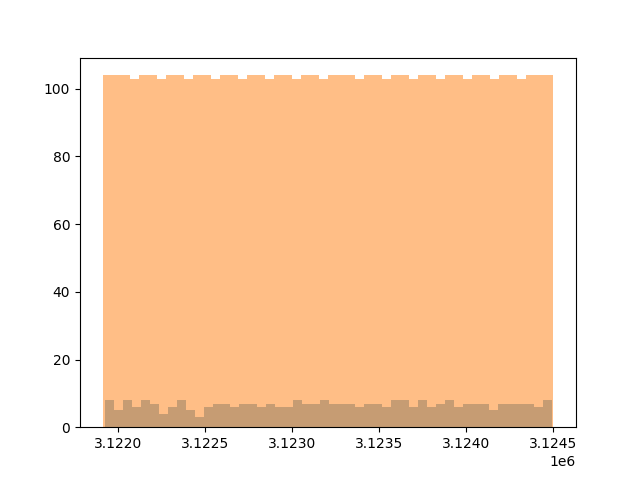

In [22]:
fig = plt.figure()
plt.hist(trial_starts, bins=50, alpha=0.5, label='trial starts')
plt.hist(bin_starts_tmp, bins=50, alpha=0.5)

In [22]:
    pupil_baseline, bin_centers = bin_timeseries_around_align({'time': pupil_times, 'value': pupil_values},
                                                session_tbl_curr['goCue_start_time'].values,
                                                step_size=1.9,
                                                bin_size=1.9,
                                                t_start=-2,
                                                t_stop=0)
    pupil_baseline = pupil_baseline.flatten()

In [35]:
pupil_dia_binned_no_trial[mask]

array([-1.25906267, -1.06990114, -1.46491296, ..., -0.93708862,
       -0.60951583, -0.68243126])

In [20]:
spikes.shape

(2, 335)

In [14]:
spike_times, session_tbl_curr['goCue_start_time'].values,

(array([3121899.288, 3121899.595, 3121899.802, ..., 3124545.242,
        3124545.758, 3124545.958]),
 array([3121928.541, 3121932.97 , 3121937.382, 3121944.86 , 3121950.457,
        3121958.899, 3121967.474, 3121973.408, 3121981.462, 3121986.994,
        3121997.146, 3122007.577, 3122024.076, 3122038.028, 3122042.831,
        3122048.607, 3122053.516, 3122057.974, 3122064.908, 3122073.541,
        3122077.699, 3122085.827, 3122101.342, 3122107.058, 3122115.981,
        3122120.663, 3122124.882, 3122136.249, 3122141.435, 3122150.682,
        3122155.366, 3122165.001, 3122169.65 , 3122175.578, 3122184.918,
        3122191.281, 3122196.906, 3122201.506, 3122208.467, 3122218.482,
        3122223.096, 3122236.417, 3122247.656, 3122260.43 , 3122272.258,
        3122283.987, 3122288.353, 3122294.74 , 3122303.534, 3122308.823,
        3122322.959, 3122331.289, 3122346.244, 3122351.162, 3122357.387,
        3122363.914, 3122368.121, 3122374.848, 3122382.84 , 3122387.856,
        3122392.672, 31

In [3]:
session_tbl_curr['goCue_start_time'].values

array([3121928.541, 3121932.97 , 3121937.382, 3121944.86 , 3121950.457,
       3121958.899, 3121967.474, 3121973.408, 3121981.462, 3121986.994,
       3121997.146, 3122007.577, 3122024.076, 3122038.028, 3122042.831,
       3122048.607, 3122053.516, 3122057.974, 3122064.908, 3122073.541,
       3122077.699, 3122085.827, 3122101.342, 3122107.058, 3122115.981,
       3122120.663, 3122124.882, 3122136.249, 3122141.435, 3122150.682,
       3122155.366, 3122165.001, 3122169.65 , 3122175.578, 3122184.918,
       3122191.281, 3122196.906, 3122201.506, 3122208.467, 3122218.482,
       3122223.096, 3122236.417, 3122247.656, 3122260.43 , 3122272.258,
       3122283.987, 3122288.353, 3122294.74 , 3122303.534, 3122308.823,
       3122322.959, 3122331.289, 3122346.244, 3122351.162, 3122357.387,
       3122363.914, 3122368.121, 3122374.848, 3122382.84 , 3122387.856,
       3122392.672, 3122398.238, 3122404.27 , 3122414.67 , 3122427.779,
       3122447.07 , 3122451.955, 3122462.334, 3122496.469, 31225

In [26]:
bin_centers.shape, spike_counts.shape, pupil_dia_binned.shape, bin_edges.shape

((5186,), (5185,), (5186,), (5186,))